In [1]:
from src import *

In [ ]:
import seaborn as sns

## Description

Comparing aligned gradient's centroid and concentration and their evolution over time versus item timeseries

GOAL: Item timeseries correlation / metrics against centroid and concentration timeseries

## Table of Contents
- [Timeseries Comparison](#comparison)

<a class="anchor" id="comparison"></a>
### Timeseries Comparison 
Comparison between item timeseries and centroid of region timeseries

Movie name used for gradient: `'TC_400_sub-S09_ses-4_Sintel.csv'`

In [7]:
# Loading Gradient Example
mri_path = "./data/fmri_compile.csv"
weight_path = "./resources/dynamic_grad/gradient_movie_ws140.npy"
mri_df   = pd.read_csv(mri_path)
regions  = mri_df.partial_region.unique()
G_movie  = np.load(weight_path)
G_rest   = np.load('./resources/dynamic_grad/gradient_rest_ws140.npy')


# Loading Matching Emotion Track
emo_df = pd.read_csv('./data/emotion_compile.csv')
emo_df = emo_df[emo_df['filename']=='W_Sintel13.csv']

In [8]:
index2region = load('./resources/yeo7region400.pkl')

Text(0.5, 0.98, 'Movie Gradient 1: region centroids position shift and concentration')

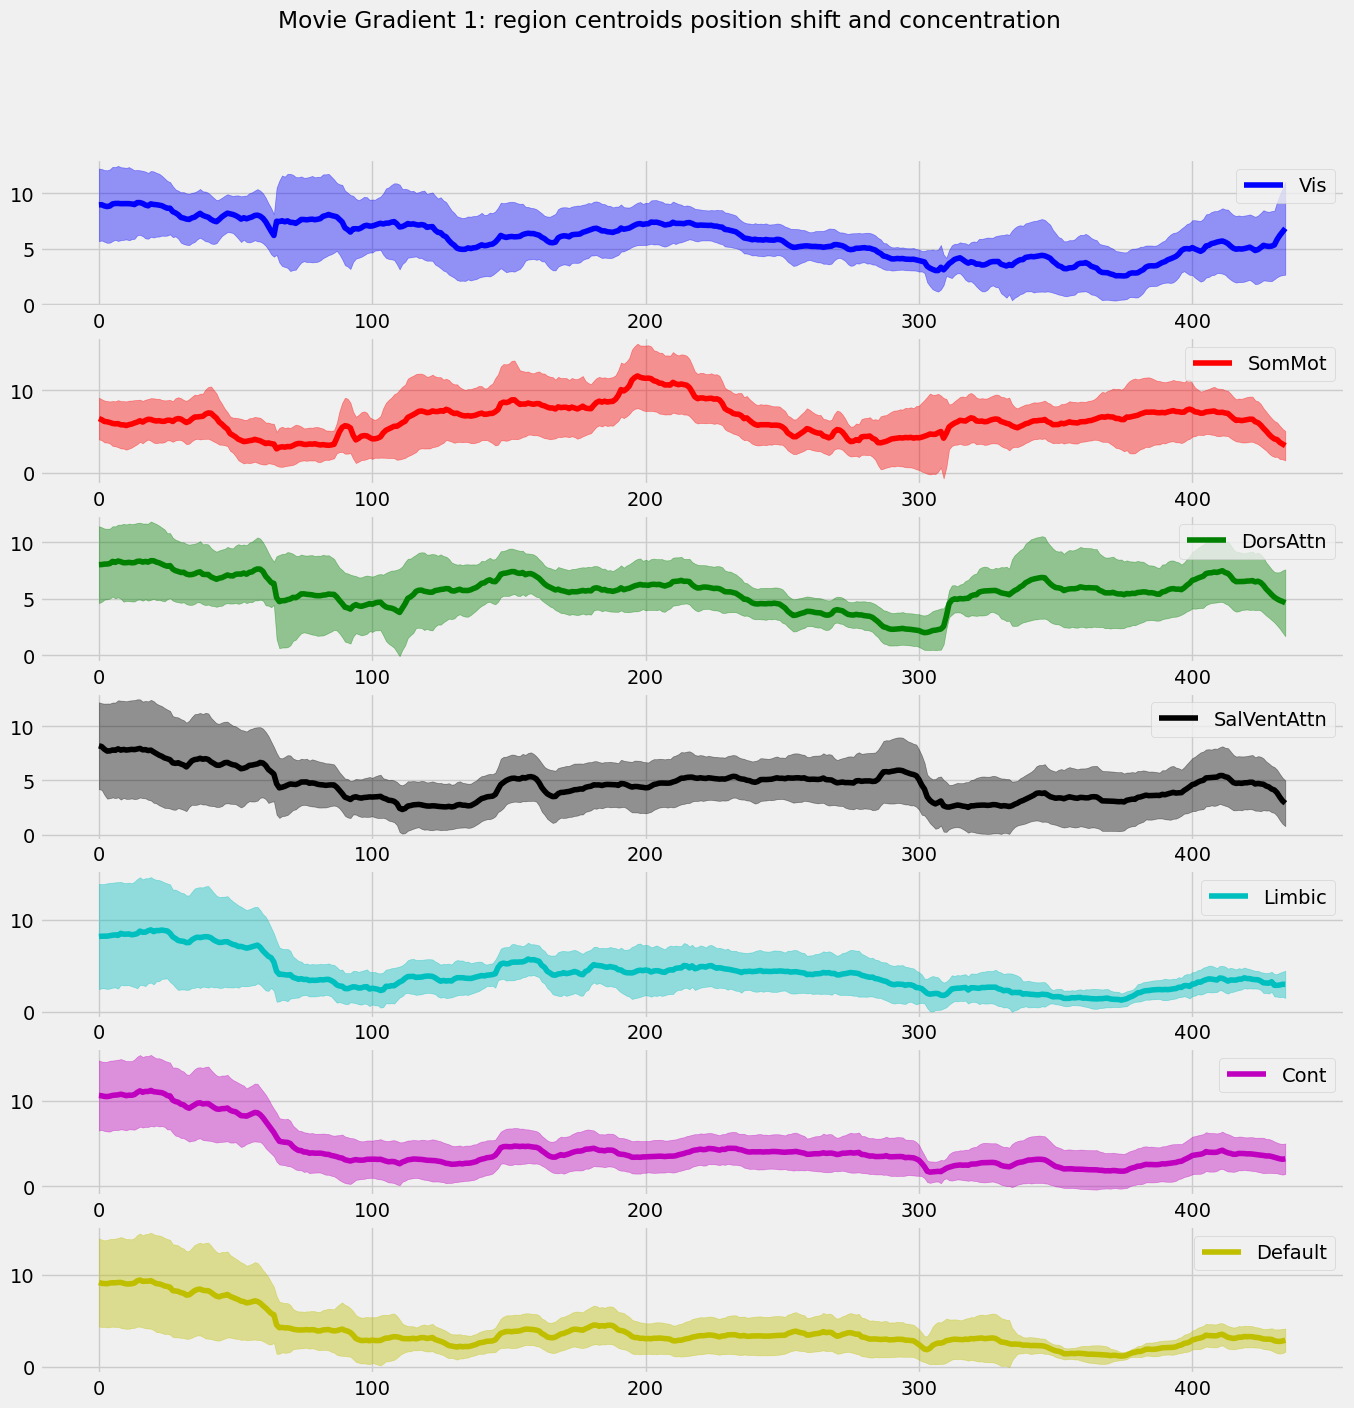

In [9]:
n = len(regions)
fig, ax = plt.subplots(n,1,figsize=(15,15))
grad_idx = 0
for idx, R in enumerate(regions):
    y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].legend()
    # ax[idx].set_ylim(0, 30)
plt.suptitle("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

Text(0.5, 0.98, 'Movie Gradient 1: region concentration')

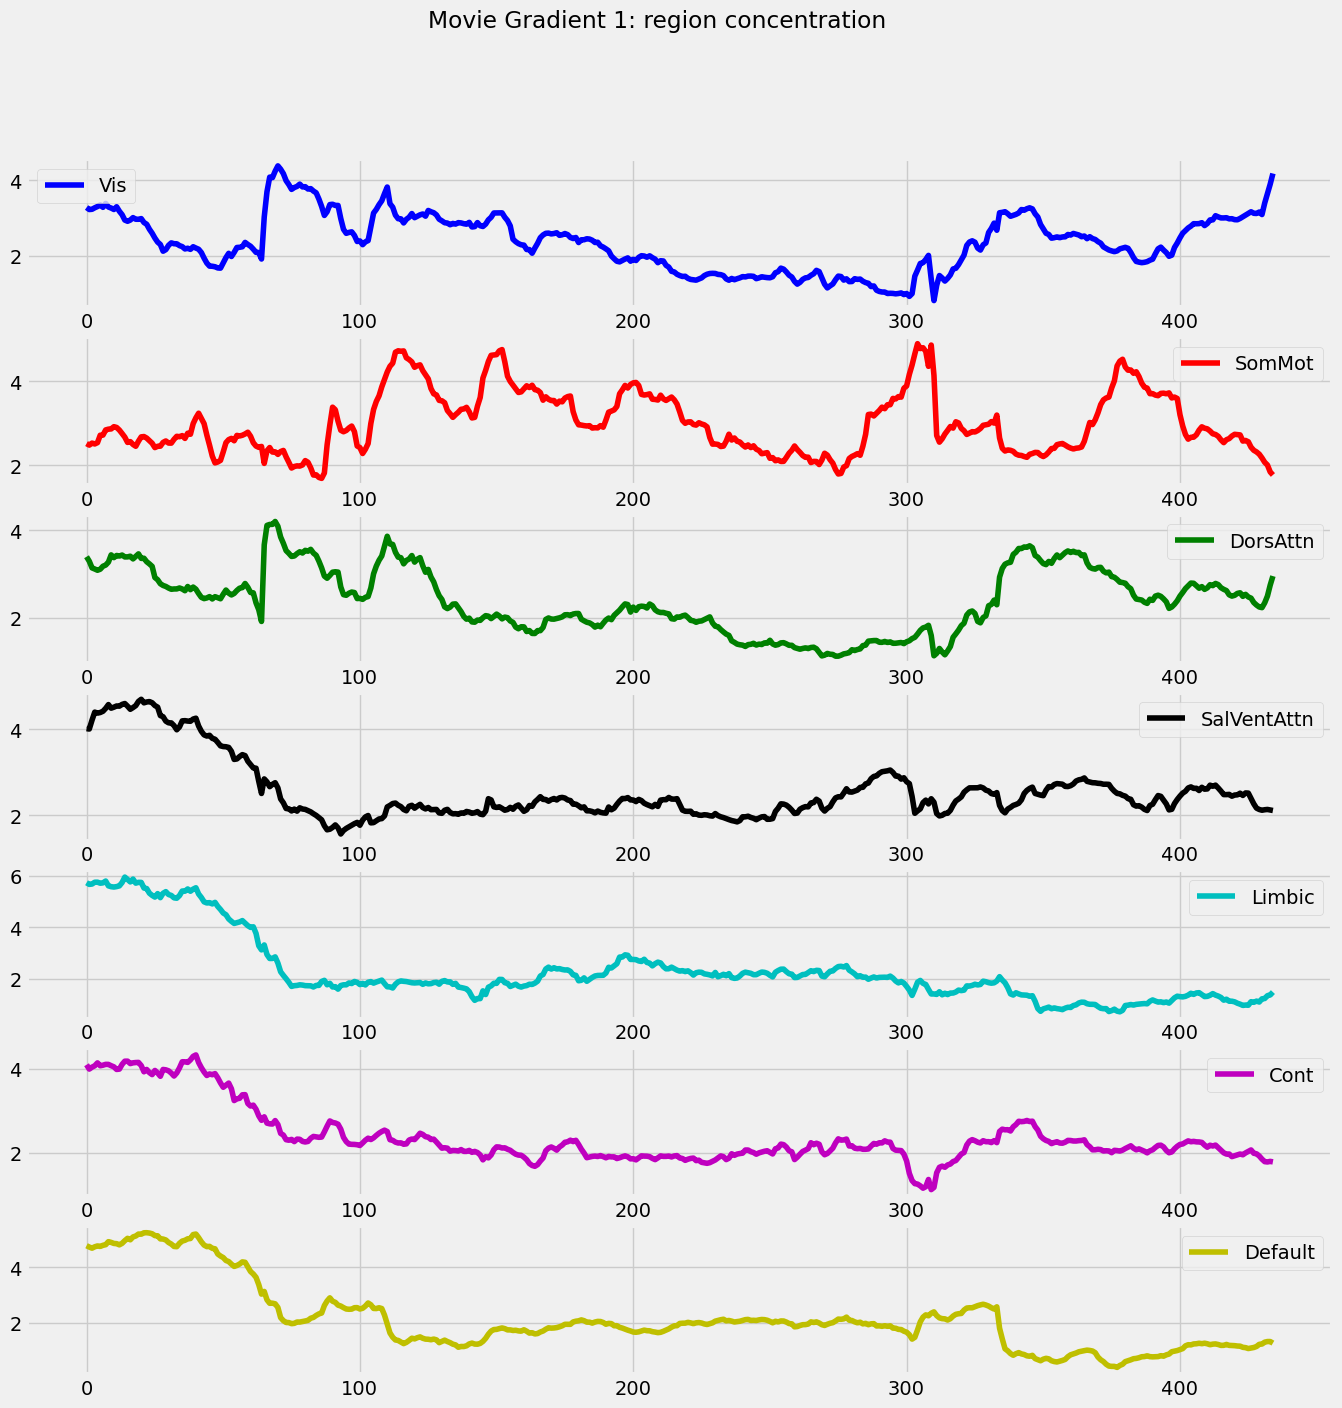

In [10]:
n = len(regions)
fig, ax = plt.subplots(n,1,figsize=(15,15))
grad_idx = 0
for idx, R in enumerate(regions):
    y = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].legend()
    # ax[idx].set_ylim(0, 30)
plt.suptitle("Movie Gradient {}: region concentration".format(grad_idx + 1))

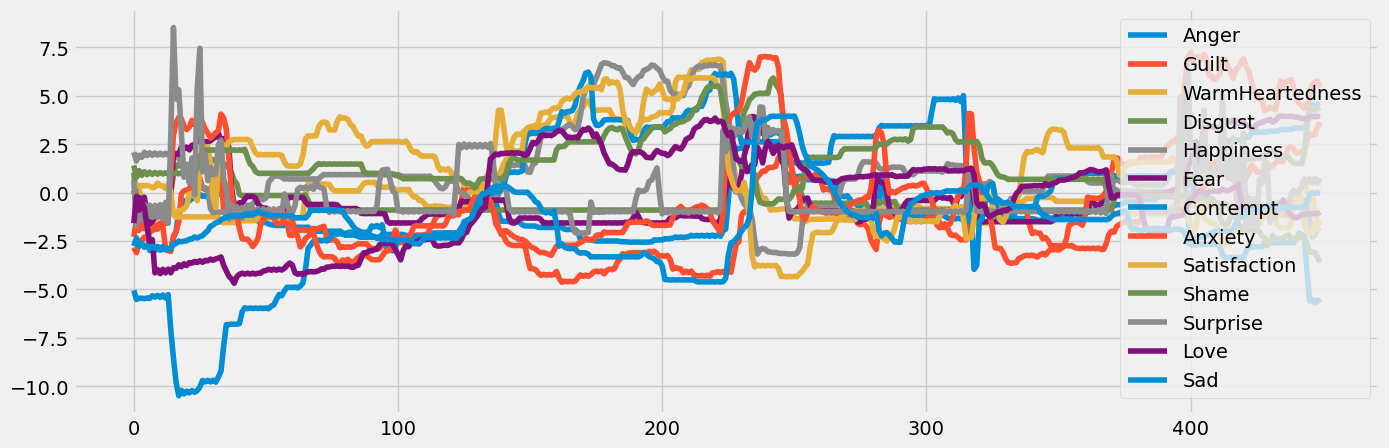

In [11]:
# emotions = "Interest, Joy, Surprise, Sadness, Anger, Disgust, Contempt, Self-Hostility, Fear, Shame, Shyness, Guilt".split(',')
# select   = ["Anxiety", "Anger", "Sad",  "Calm", "Satisfaction",  "Love", "Happiness", "Alert"]
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

plt.figure(figsize=(15,5))
for emotion in select:
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])[:450]
    plt.plot(emo_series, label=emotion)

plt.legend()

In [12]:
# Grid for each network of correlation with emotions
grad_idx = 0
smfactor = 1
tolshift = 0

n = len(regions)
m = len(select)

scores = np.zeros((n,m))

for idx, R in enumerate(regions):
    # Metric we use here would be variance of a cluster
    y = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]
    # y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores[idx,jdx] = corr

In [39]:
# For each region generate correlation with emotions
smfactor = 1
tolshift = 0

n = G_movie.shape[1]
m = len(select)

scores2 = np.zeros((n,m))

for idx in tqdm(range(n)):
    # Metric we use here is movement of point on the manifold
    tmpA = G_movie[:, idx][:-1]
    tmpB = G_movie[:, idx][1:]

    y    = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
            for pidx in range(len(tmpA))])
    z1   = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores2[idx,jdx] = corr


100%|██████████| 400/400 [00:09<00:00, 40.27it/s]


#### Correlation brain maps with 7 networks
We select here the max and visualize how well they correlate each other

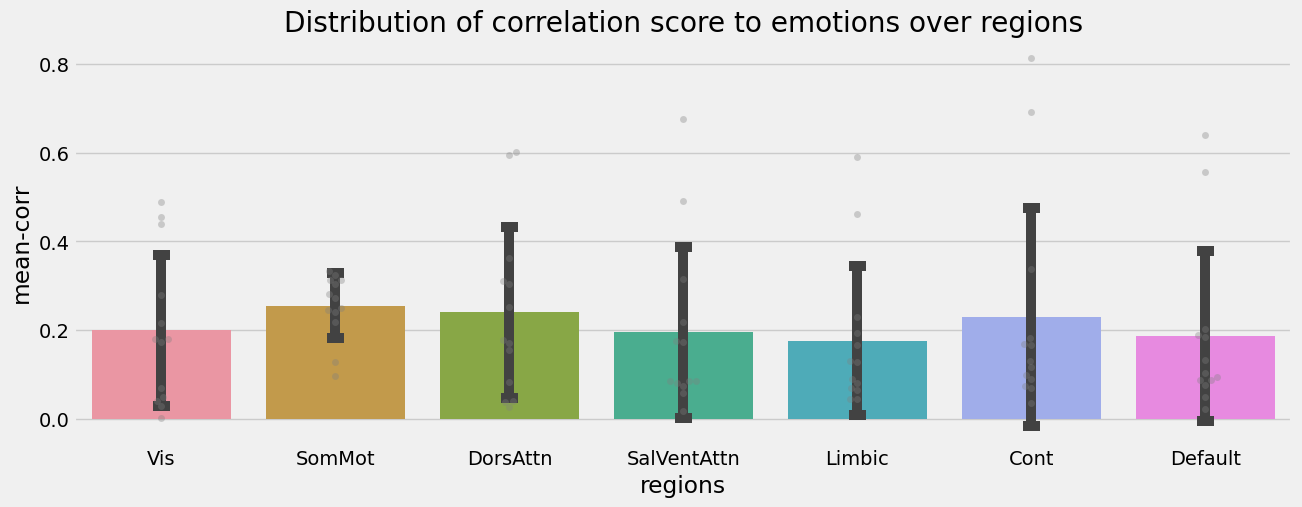

In [34]:
concat_region = np.concatenate([[r] * scores.shape[1] for r in regions])
corr_score = {'regions': concat_region, 'mean-corr': np.abs(scores.flatten())}
plt.figure(figsize=(14,5))
sns.barplot(x="regions", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(x="regions", y="mean-corr", data=corr_score, color="0.5", alpha=.35)
plt.title("Distribution of correlation score to emotions over regions")
plt.show()

In [58]:
print(scores.max(), scores.argmax(), scores.argmax()//m, scores.argmax()%m)
print(20//m,20%m)
print(45//m,45%m)
print(21//m,21%m)
print(4//m,4%m)

0.32372764856610337 14 1 6
2 4
5 5
2 5
0 4


(0.32372764856610337, (0, 0), 4.527489903954968e-12)


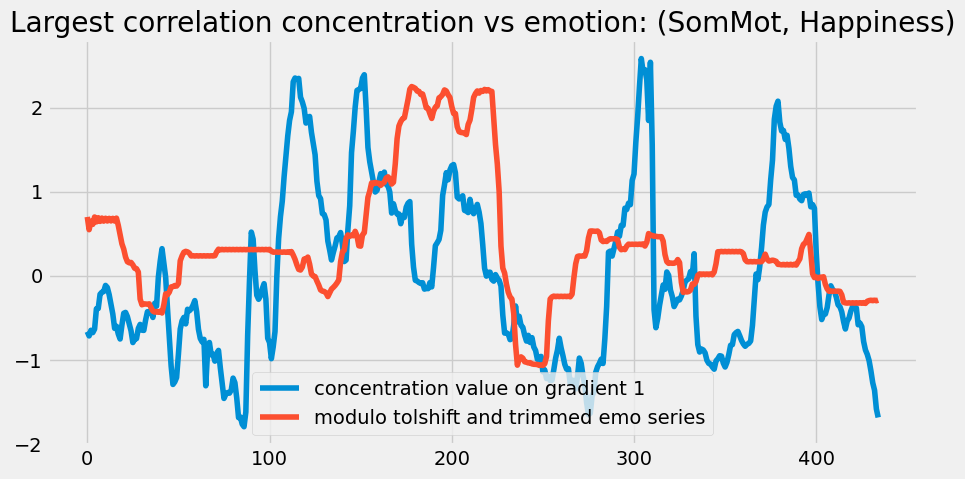

In [74]:
idxa = 1
idxb = 6
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

(0.31130899217629054, (0, 0), 3.139257132851359e-11)


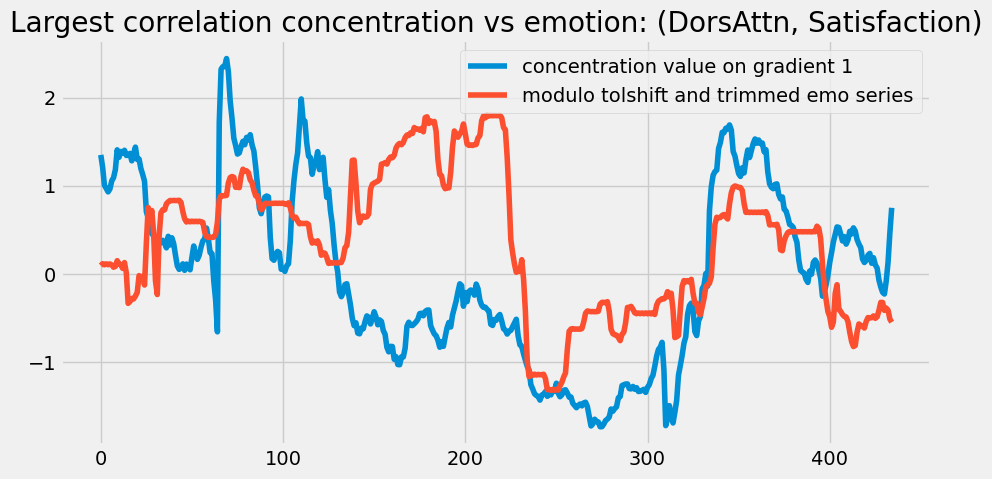

In [75]:
idxa = 2
idxb = 4
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

(-0.6914115337466729, (0, 0), 4.067233116135134e-63)


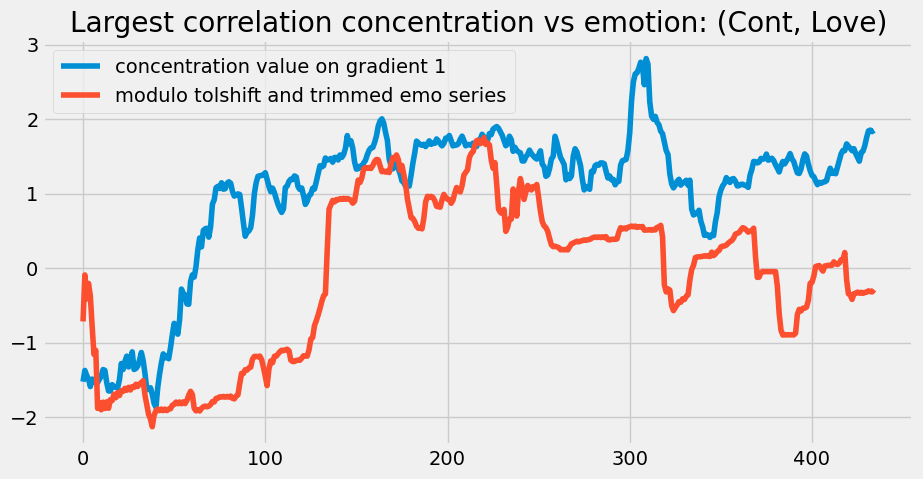

In [76]:
idxa = 5
idxb = 5
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(1-a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

(-0.6022046045171082, (0, 0), 2.8167086073835966e-44)


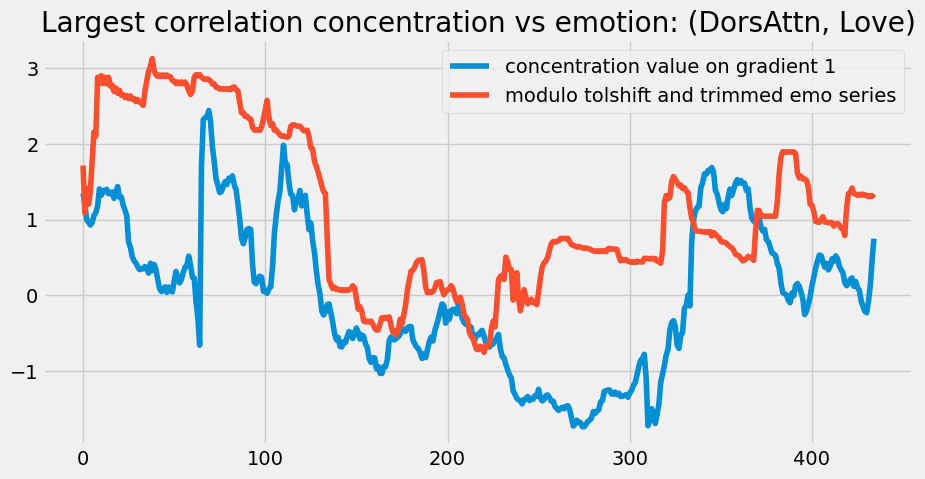

In [77]:
idxa = 2
idxb = 5
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(1-b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

#### Correlation brain maps with 400 parcellations

In [45]:
from copy import deepcopy

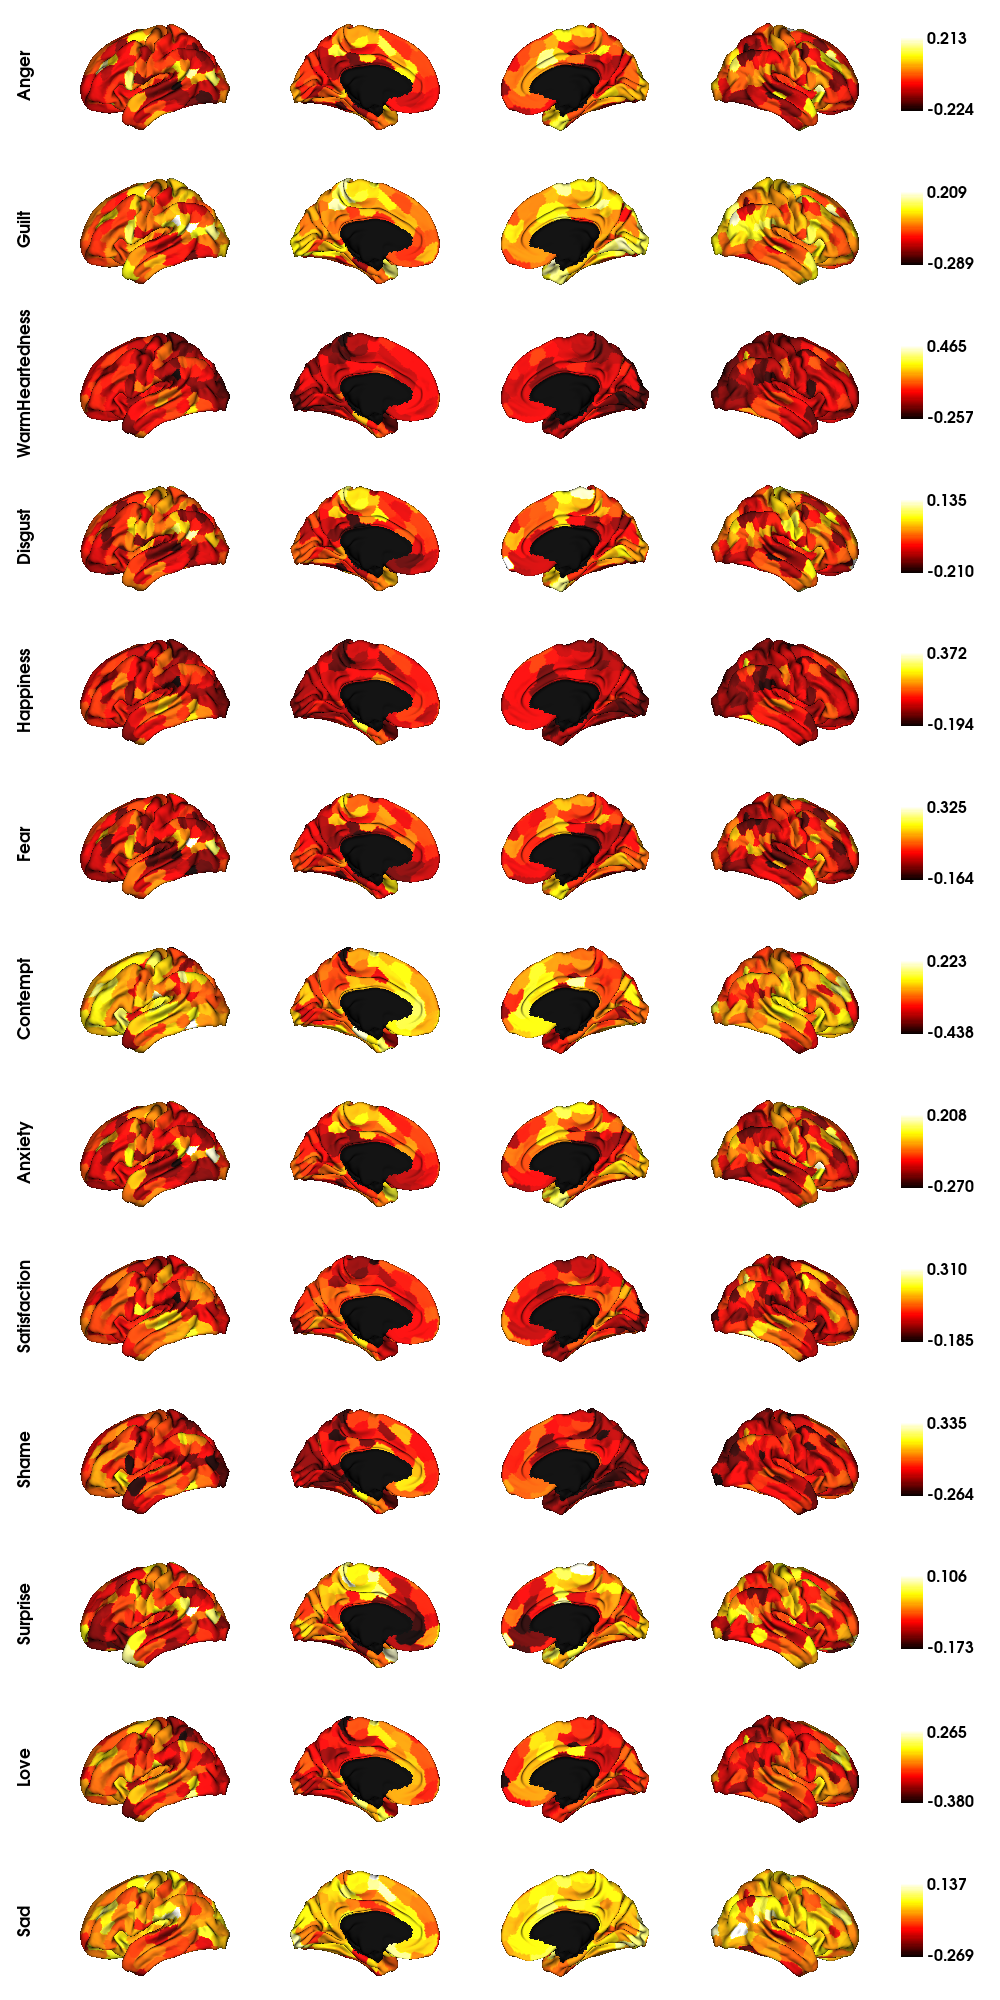

: 

In [50]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = deepcopy(scores2.T)

grad = [None] * len(select)
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)


plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='hot',
                 color_bar=True, label_text=select, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)
